# Active Learning

## Problem setup: 
On an 8x8 gridworld grid, 90% of the squares have no reward and 10% have fixed reward (uniform [0,1]).
The agent normally doesn't see the reward, but it can pay a fixed 'query' cost to see it. 

We use Posterior Sampling Reinforcement Learning to do the learning. We use N(0,1) for the reward distributions.

As a heuristic method, we separate the problem into PSRL and a choice of whether to query at the time an action is chosen. We try several different heuristic query choice functions: 

1. QueryFirstN, queries the first n state action pairs encountered
1. QueryFirstNVisits, queries the first some number of times that it visits a state action pair
2. RewardProportional, probabilistically queries proportionally to the fraction of the total expected reward of the current state action (relative to the total of all pairs).
3. EntropyThreshold, queries based on whether the current distribution has entropy larger than a certain amount

In [7]:
%pylab inline
import numpy as np
import argparse
import gridworld
import query_functions
import finite_tabular_agents

seed = np.random.randint(10000) #1
numpy_rng = np.random.RandomState(seed)

from feature_extractor import FeatureTrueState
from experiment import run_finite_tabular_experiment

# AGENT

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [ ]:
def runexp(nEps, epLen, scaling, alg, grid_width, prob_zero_reward, query_function, hasP=True):
    targetPath = 'test.csv'

    # reward probabilities
    states = range(grid_width**2)
    reward_probabilities = numpy_rng.binomial(1, 1 - prob_zero_reward, len(states)) * numpy_rng.uniform(0, 1, len(states))

    # Make the environment
    env = gridworld.make_gridworld(grid_width, epLen, reward_probabilities)

    f_ext = FeatureTrueState(env.epLen, env.nState, env.nAction, env.nState)

    P_true =env.P
    if not hasP: 
        P_true=False
        
    # Make the agent
    agent = alg(env.nState, env.nAction, env.epLen,
                              scaling=scaling, 
                              P_true=env.P, R_true=False)
    query_function.setEnvAgent(env, agent)

    # Run the experiment
    return run_finite_tabular_experiment(agent, env, f_ext, nEps, seed,
                        recFreq=1000, fileFreq=10000, targetPath=targetPath, query_function=query_function)

In [30]:
def perfplot(ns, x, desc):
    figure()
    plot(ns, x, '.');
    plot(ns, np.mean(x, axis=1), '--');
    title(desc)

We first look at the performance of EpsilonGreedy assuming no query costs.

In [9]:
iters = 20
nvisitsExperiments = lambda x : [ runexp(
    nEps=50,
    epLen = 15,
    scaling = 1,
    alg = finite_tabular_agents.EpsilonGreedy,
    grid_width = 8, #8x8 grid, 
    prob_zero_reward = .9,
    query_function = query_functions.QueryFirstNVisits(2, x)
    ) for i in range(iters)]

ns = [0,1,2,4,8,12]
ys = np.array(map(nvisitsExperiments,ns))

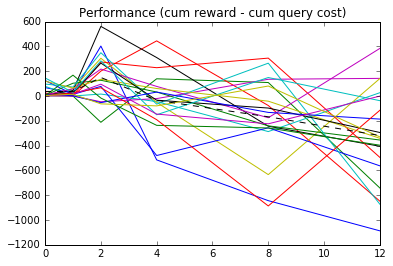

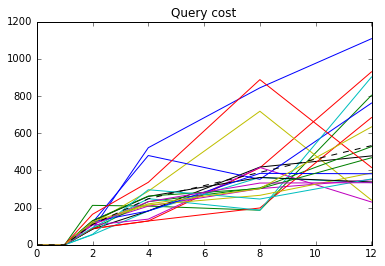

In [10]:
perfplot(ns, ys[:,:,2], "performance (cum reward - cum query cost)")
perfplot(ns, ys[:,:,1], "query cost ")

We see that Epsilon Greedy is super noisy, but shows a peak at sampling 2 times at every point, then getting worse steadily.

PSRL
----
The same experiment.

In [12]:
iters = 20
nvisitsExperiments = lambda x : [ runexp(
    nEps=50,
    epLen = 15,
    scaling = 1,
    alg = finite_tabular_agents.PSRL,
    grid_width = 8,
    prob_zero_reward = .9,
    query_function = query_functions.QueryFirstNVisits(2, x)
    ) for i in range(iters)]

ns = [0,1,2,4,8,12]
ys = np.array(map(nvisitsExperiments,ns))

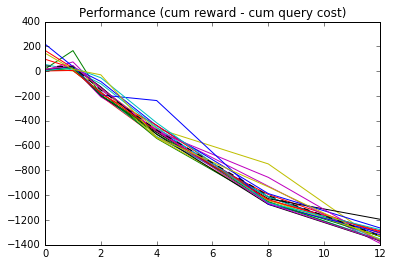

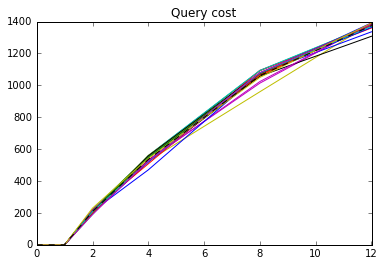

In [13]:
perfplot(ns, ys[:,:,2], "performance (cum reward - cum query cost)")
perfplot(ns, ys[:,:,1], "query cost ")

Surprisingly PSRL seems to perform worse than Epsilon Greedy. We're not sure what's happening here. 

The query costs rise fster for PSRL, so there seems to be some sense in which PSRL is over exploring here. This is surprising because if anything, PSRL should be underestimating the average rewards. 

Now we run similar experiments but with different query functions

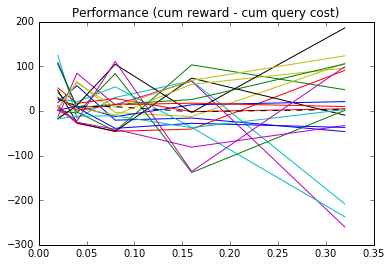

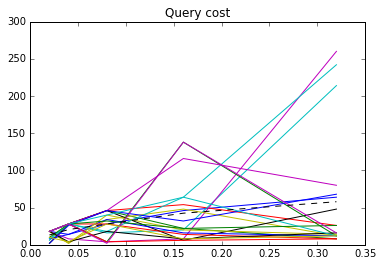

In [14]:
iters = 20
nvisitsExperiments = lambda x : [ runexp(
    nEps=50,
    epLen = 15,
    scaling = 1,
    alg = finite_tabular_agents.PSRL,
    grid_width = 8,
    prob_zero_reward = .9,
    query_function = query_functions.RewardProportional(2, x)
    ) for i in range(iters)]

ns = [.02,.04,.08,.16,.32]
ys = np.array(map(nvisitsExperiments,ns))

perfplot(ns, ys[:,:,2], "performance (cum reward - cum query cost)")
perfplot(ns, ys[:,:,1], "query cost ")

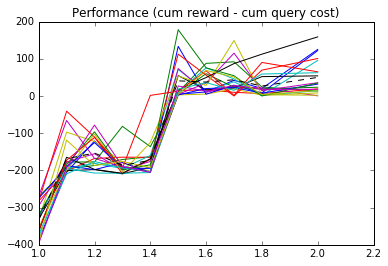

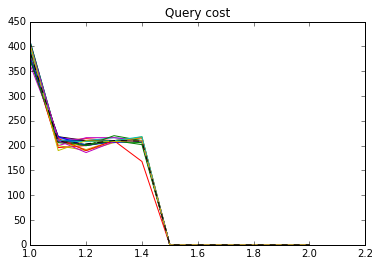

In [15]:
iters = 20
nvisitsExperiments = lambda x : [ runexp(
    nEps=50,
    epLen = 15,
    scaling = 1,
    alg = finite_tabular_agents.PSRL,
    grid_width = 8,
    prob_zero_reward = .9,
    query_function = query_functions.EntropyThreshold(2, x)
    ) for i in range(iters)]

ns = [1, 1.1, 1.2,1.3,1.4, 1.5, 1.6,1.7,1.8,2]
ys = np.array(map(nvisitsExperiments,ns))

perfplot(ns, ys[:,:,2], "performance (cum reward - cum query cost)")
perfplot(ns, ys[:,:,1], "query cost ")

Lets try Epsilon Greedy with a smaller search cost and then try PSRL to see if you can get better performance out of it.

In [17]:
iters = 20
nvisitsExperiments = lambda x : [ runexp(
    nEps=50,
    epLen = 15,
    scaling = 1,
    alg = finite_tabular_agents.EpsilonGreedy,
    grid_width = 8, #8x8 grid, 
    prob_zero_reward = .9,
    query_function = query_functions.QueryFirstNVisits(.2, x)
    ) for i in range(iters)]

ns = [0,1,2,4,8,12]
ys = np.array(map(nvisitsExperiments,ns))

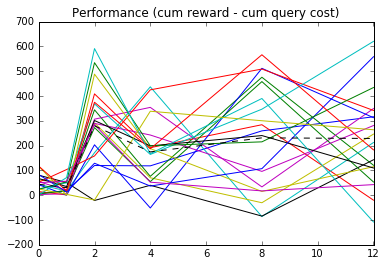

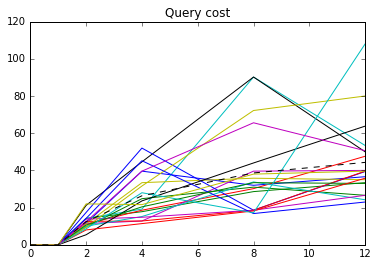

In [18]:
perfplot(ns, ys[:,:,2], "performance (cum reward - cum query cost)")
perfplot(ns, ys[:,:,1], "query cost ")

Now try PSRL

In [19]:
iters = 20
nvisitsExperiments = lambda x : [ runexp(
    nEps=50,
    epLen = 15,
    scaling = 1,
    alg = finite_tabular_agents.PSRL,
    grid_width = 8, #8x8 grid, 
    prob_zero_reward = .9,
    query_function = query_functions.QueryFirstNVisits(.2, x)
    ) for i in range(iters)]

ns = [0,1,2,4,8,12]
ys = np.array(map(nvisitsExperiments,ns))

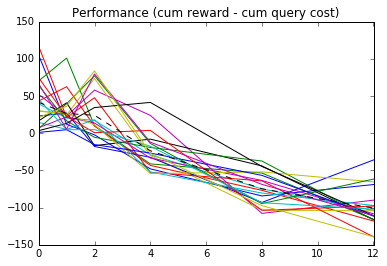

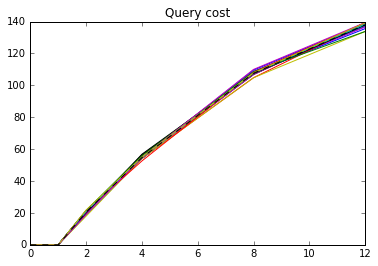

In [20]:
perfplot(ns, ys[:,:,2], "performance (cum reward - cum query cost)")
perfplot(ns, ys[:,:,1], "query cost ")

Now try with a longer episode length time.

In [21]:
iters = 20
nvisitsExperiments = lambda x : [ runexp(
    nEps=50,
    epLen = 35,
    scaling = 1,
    alg = finite_tabular_agents.PSRL,
    grid_width = 8, #8x8 grid, 
    prob_zero_reward = .9,
    query_function = query_functions.QueryFirstNVisits(.2, x)
    ) for i in range(iters)]

ns = [0,1,2,4,8,12]
ys = np.array(map(nvisitsExperiments,ns))

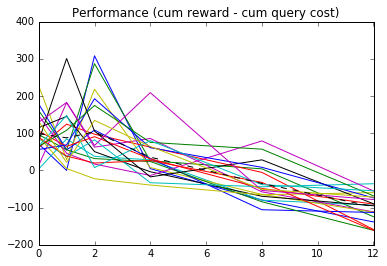

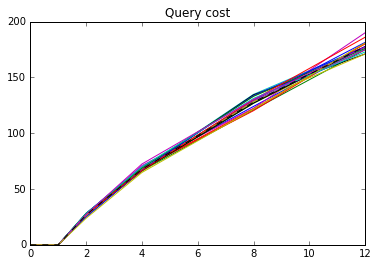

In [22]:
perfplot(ns, ys[:,:,2], "performance (cum reward - cum query cost)")
perfplot(ns, ys[:,:,1], "query cost ")

Another trial with zero cost.

In [23]:
iters = 20
nvisitsExperiments = lambda x : [ runexp(
    nEps=50,
    epLen = 35,
    scaling = 1,
    alg = finite_tabular_agents.PSRL,
    grid_width = 8, #8x8 grid, 
    prob_zero_reward = .9,
    query_function = query_functions.QueryFirstNVisits(0, x)
    ) for i in range(iters)]

ns = [0,1,2,4,8,12]
ys = np.array(map(nvisitsExperiments,ns))

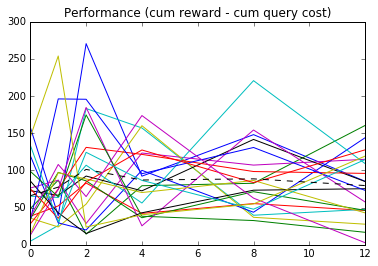

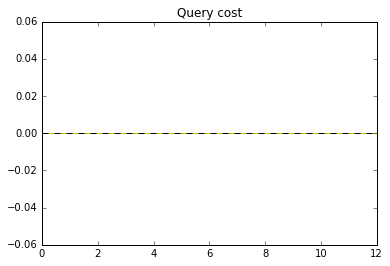

In [24]:
perfplot(ns, ys[:,:,2], "performance (cum reward - cum query cost)")
perfplot(ns, ys[:,:,1], "query cost ")

Now try with a many more episodes

episode: 100 epReward: 1.59891486934 epQueryCost: 0 perf: 235.236400805 cumRegret: 2427.80163741
episode: 200 epReward: 0.0 epQueryCost: 0 perf: 447.75160217 cumRegret: 4878.32447427
episode: 300 epReward: 0.0 epQueryCost: 0 perf: 728.455508358 cumRegret: 7260.6586063
episode: 400 epReward: 1.59120157264 epQueryCost: 0 perf: 944.502875329 cumRegret: 9707.64927754
episode: 500 epReward: 0.0 epQueryCost: 0 perf: 1130.1747551 cumRegret: 12185.015436
episode: 600 epReward: 0.0 epQueryCost: 0 perf: 1250.92959789 cumRegret: 14727.2986314
episode: 700 epReward: 0.0 epQueryCost: 0 perf: 1399.88423841 cumRegret: 17241.3820291
episode: 800 epReward: 1.29896325504 epQueryCost: 0 perf: 1616.05993036 cumRegret: 19688.2443754
episode: 900 epReward: 0.0 epQueryCost: 0 perf: 1947.0636785 cumRegret: 22020.2786655
episode: 1000 epReward: 0.870855729503 epQueryCost: 0 perf: 2236.23255242 cumRegret: 24394.1478298
episode: 100 epReward: 0.0229289439974 epQueryCost: 0 perf: 106.806534326 cumRegret: 1957.308

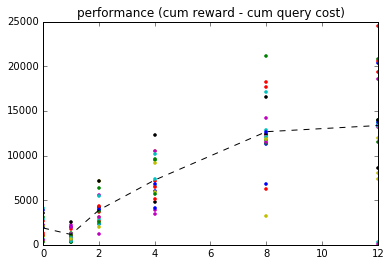

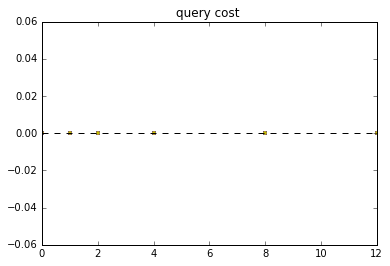

In [34]:
iters = 20
nvisitsExperiments = lambda x : [ runexp(
    nEps=1000,
    epLen = 35,
    scaling = 1,
    alg = finite_tabular_agents.PSRL,
    grid_width = 8, #8x8 grid, 
    prob_zero_reward = .9,
    query_function = query_functions.QueryFirstNVisits(0, x)
    ) for i in range(iters)]

ns = [0,1,2,4,8,12]
ys = np.array(map(nvisitsExperiments,ns))

perfplot(ns, ys[:,:,2], "performance (cum reward - cum query cost)")
perfplot(ns, ys[:,:,1], "query cost ")

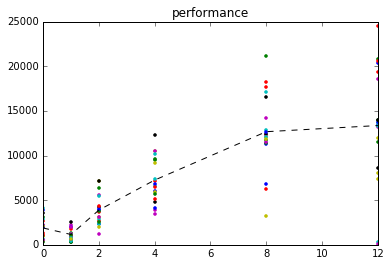

In [35]:
perfplot(ns, ys[:,:,2], "performance")

In [ ]:
iters = 3
nvisitsExperiments = lambda x : [ runexp(
    nEps=100,
    epLen = 15,
    scaling = 1,
    alg = finite_tabular_agents.PSRL,
    grid_width = 8, #8x8 grid, 
    prob_zero_reward = .9,
    query_function = query_functions.QueryFirstNVisits(0, x), hasP=False
    ) for i in range(iters)]

ns = [0,1,2,4,8,12]
ys = np.array(map(nvisitsExperiments,ns))

perfplot(ns, ys[:,:,2], "performance (cum reward - cum query cost)")
perfplot(ns, ys[:,:,1], "query cost ")

episode: 100 epReward: 0.12790671213 epQueryCost: 0 perf: 84.2482513311 cumRegret: 686.728972968
episode: 100 epReward: 0.0 epQueryCost: 0 perf: 40.4267955602 cumRegret: 892.050601795
episode: 100 epReward: 1.77295685151 epQueryCost: 0 perf: 347.762568385 cumRegret: 977.55149376
episode: 100 epReward: 0.8977228712 epQueryCost: 0 perf: 149.621847401 cumRegret: 1017.41788516
episode:

In [16]:
%load_ext line_profiler


In [5]:
%lprun -f finite_tabular_agents.FiniteHorizonTabularAgent.compute_qVals runexp(nEps=50,epLen = 15,scaling = 1,alg = finite_tabular_agents.PSRL, grid_width = 8,prob_zero_reward = .9,query_function = query_functions.EntropyThreshold(2, .5) )